# Setup

## Mount Filesystem

In [2]:
# Set up colab filesystem
import os
import sys
os.environ['NOTEBOOK_MODE'] = '1'
from google.colab import drive

os.chdir('/content')
drive.mount('drive')
WORKDIR = 'drive/MyDrive/Colab Notebooks/ECE661/Project' # Change to location in drive
sys.path.append(WORKDIR)
os.chdir(WORKDIR)

Mounted at drive


## Dependencies

In [3]:
# Install python dependencies
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 6.6 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 182 kB 41.9 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 


In [4]:
# Import dependencies
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

## Constants

In [5]:
# Constants
DATA = 'CIFAR' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NUM_CLASSES_VIS = 10
DEVICE = 'cuda'

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1 
NUM_CLASSES_VIS = min(NUM_CLASSES_VIS, NUM_CLASSES)
GRAIN = 4 if DATA != 'CIFAR' else 1

## Load Dataset and Pretrained Model

In [6]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /tmp/cifar-10-python.tar.gz to /tmp/
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/CIFAR.pt'
=> loaded checkpoint './models/CIFAR.pt' (epoch 153)


AttackerModel(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, mo

In [8]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

# Image Generation

## Calculate Random Seeds

In [9]:
# Get seed distribution (can be memory intensive to do all ImageNet classes at once)

im_test, targ_test = [], []
for _, (im, targ) in enumerate(test_loader):
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = ch.cat(im_test), ch.cat(targ_test)

conditionals = []
for i in tqdm(range(NUM_CLASSES_VIS)):
    imc = im_test[targ_test == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


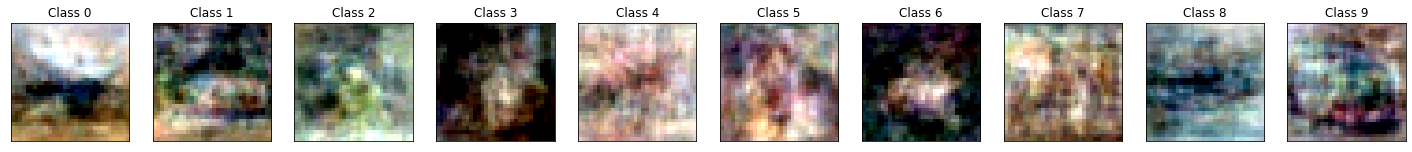

In [10]:
# Visualize seeds
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(NUM_CLASSES_VIS)])
img_seed = ch.clamp(img_seed, min=0, max=1)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(NUM_CLASSES_VIS)]])

## Generate Images

In [11]:
def generation_loss(mod, inp, targ):
    op = mod(inp)
    loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
    return loss, None

kwargs = {
        'custom_loss': generation_loss,
        'constraint':'2',
        'eps': 40,
        'step_size': 1,
        'iterations': 60,
        'targeted': True,
}  
    
if DATA == 'CIFAR':
    kwargs['eps'] = 30
    kwargs['step_size'] = 0.5
    kwargs['iterations'] = 60

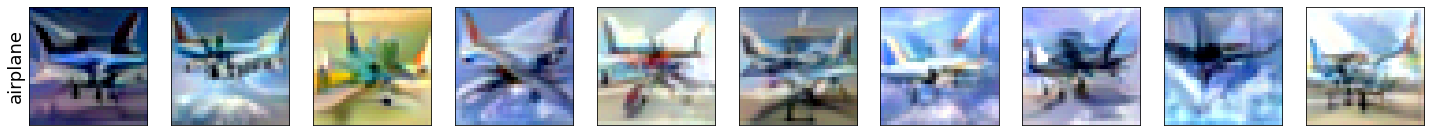

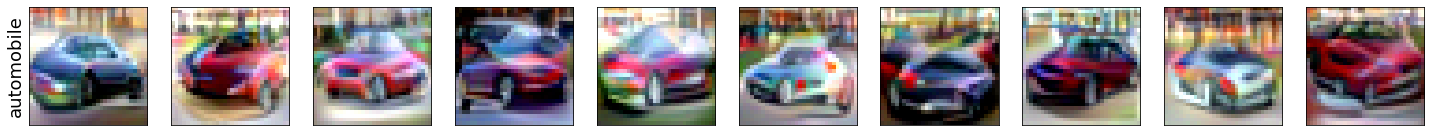

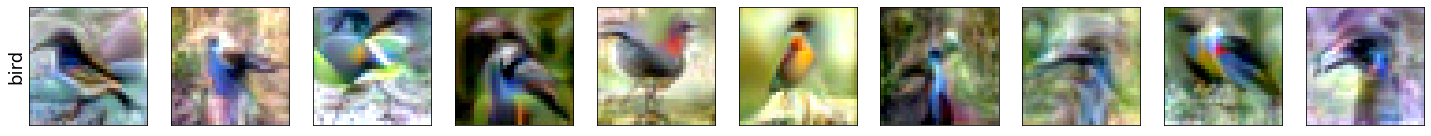

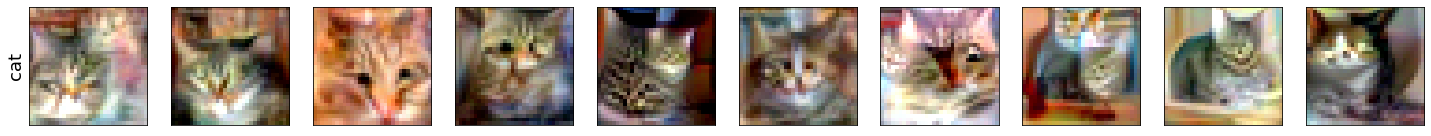

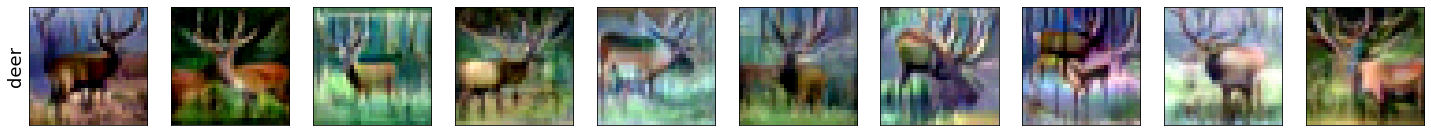

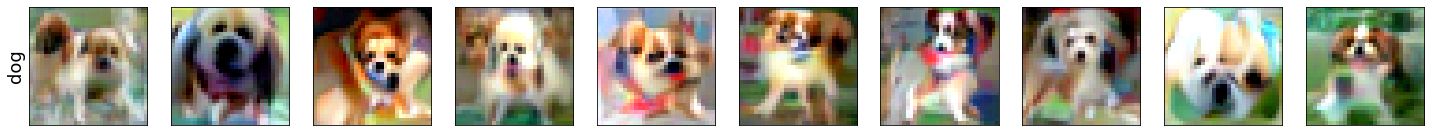

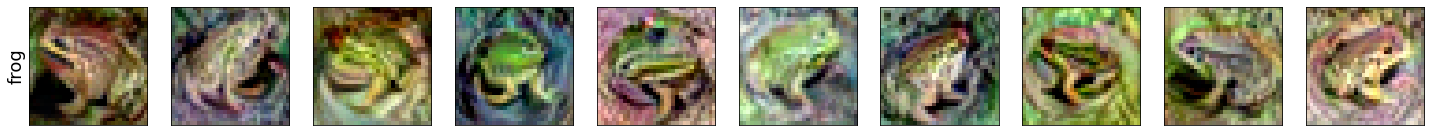

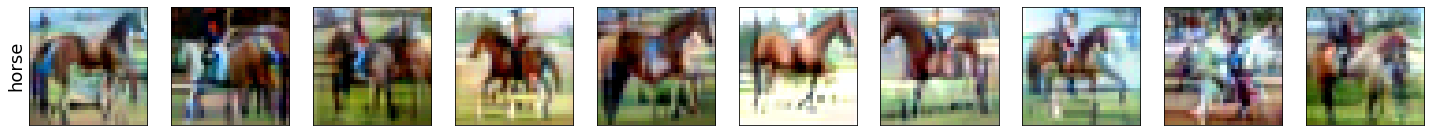

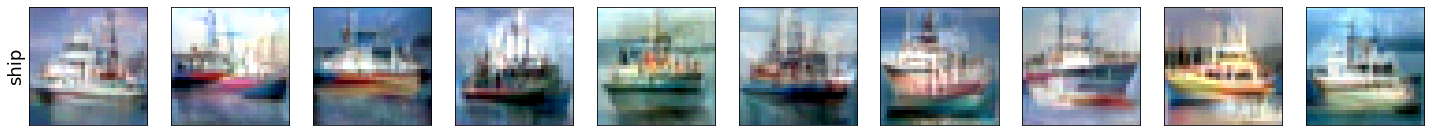

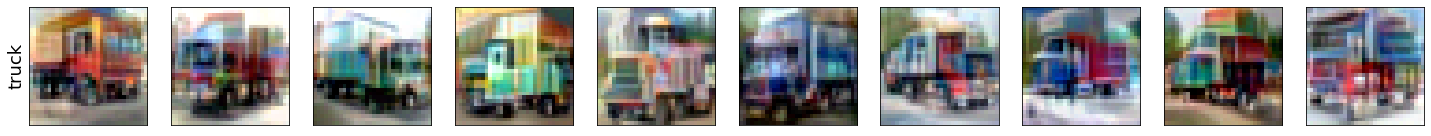

In [12]:
show_seed = False
for i in range(NUM_CLASSES_VIS):
    target_class = i * ch.ones((BATCH_SIZE, ))
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1)).to(DEVICE)
    _, im_gen = model(im_seed, target_class.long().to(DEVICE), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   [CLASSES[int(t)].split(',')[0] for t in target_class], 
                   fontsize=18)

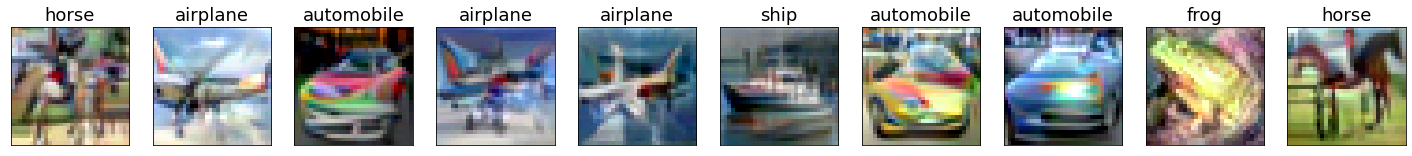

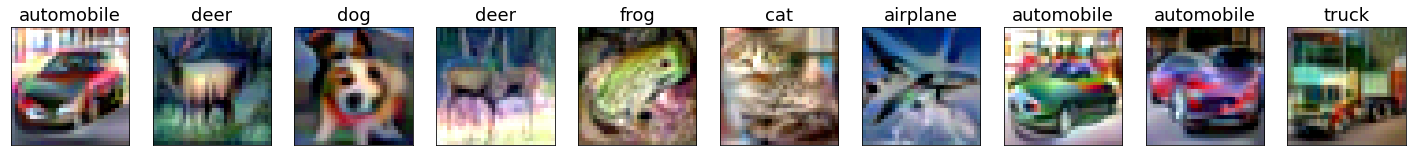

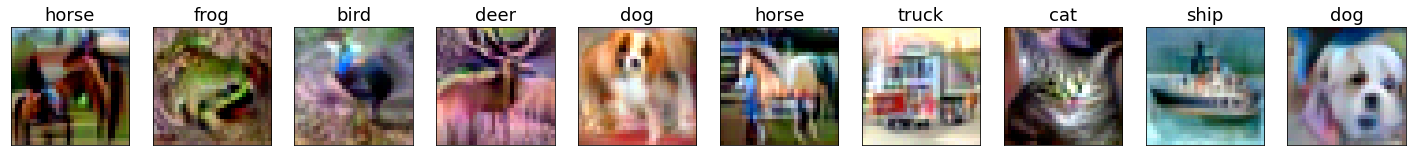

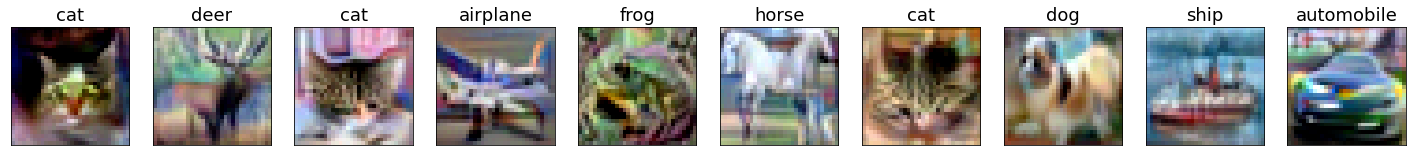

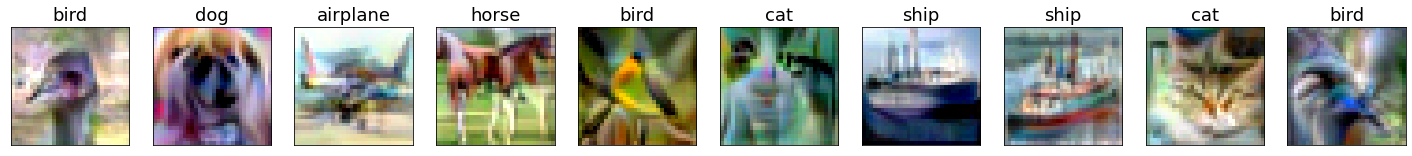

In [13]:
show_seed = False
for i in range(5):
    target_class = ch.tensor(np.random.choice(range(NUM_CLASSES_VIS), (BATCH_SIZE,)))
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1)).to('cuda')
    _, im_gen = model(im_seed, target_class.long().to('cuda'), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   tlist=[[CLASSES[int(t)].split(',')[0] for t in target_class]], 
                   fontsize=18)

# Inpainting

## Image Corruption

In [27]:
PATCH_SIZE = 6 if DATA == "CIFAR" else 60

# Function to get corrupted image
def mask_image(x, width=PATCH_SIZE):
    loc = np.random.randint(0, x.shape[-1] - PATCH_SIZE, size=(x.shape[0], 2))
    mask = ch.zeros_like(x)
    for idx in range(x.shape[0]):
        i, j = loc[idx, 0], loc[idx, 1]
        val = ch.mean(ch.mean(x[idx, :], dim=2, keepdim=True), dim=1, keepdim=True)
        # Initialize masked region as mean pixel value over image (per channel)
        x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = val.expand_as(x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE])
        mask[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = 1
    return x, mask

## Inpainting

In [28]:
# Custom inpainting loss
def inpainting_loss_wrapper(im_targ, mask, normalizer, lambdar=10):
    def inpainting_loss(mod, inp, targ):
        op = mod(normalizer(inp), fake_relu=True)
        loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
        loss_l2 = ((im_targ - inp) * (1 - mask) )**2
        loss_l2 = loss_l2.mean(-1).mean(-1).mean(-1)
        loss += lambdar * loss_l2
        return loss, None
    return inpainting_loss

In [41]:
# PGD parameters
kwargs = {
        'constraint':'2',
        'eps': 21.6,
        'step_size': 0.1,
        'iterations': 720, 
        'do_tqdm': True,
        'targeted': True,
        'should_normalize': False
}

In [42]:
# Inpainting using PGD
_, (img_orig, targ_orig) = next(data_iterator)
img_corrupt, mask = mask_image(img_orig.clone())
img_corrupt = img_corrupt.to(DEVICE)

kwargs['custom_loss'] = inpainting_loss_wrapper(img_corrupt.cuda(), 
                                                mask.cuda(), 
                                                model.normalizer)

_, img_inpaint = model(img_corrupt, targ_orig.clone().to(DEVICE), make_adv=True, **kwargs)

  0%|          | 0/720 [00:00<?, ?it/s]

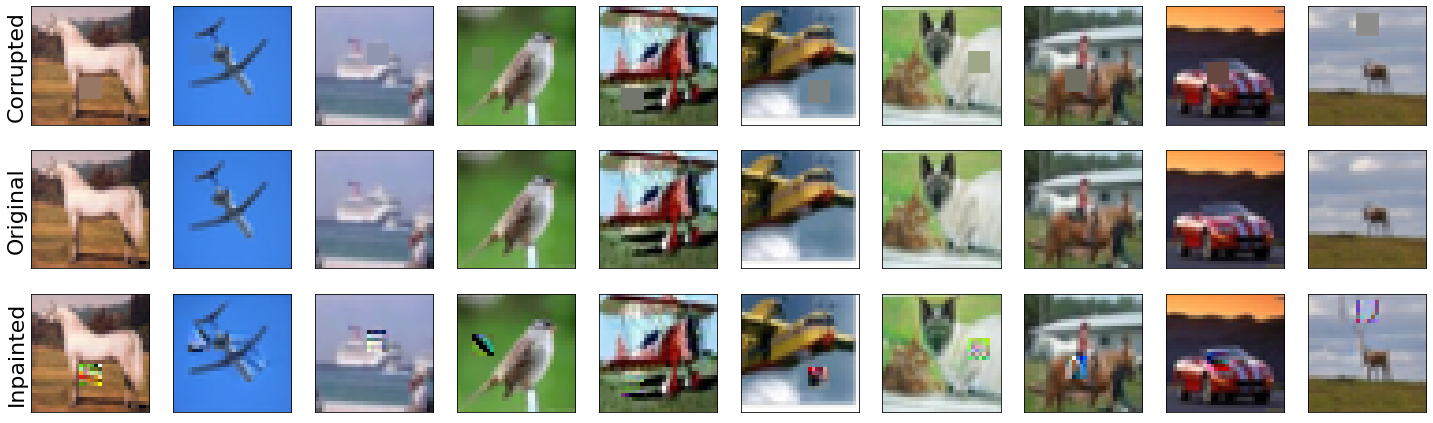

In [43]:
# Visualize inpainted images
show_image_row([img_corrupt.cpu(), img_orig.cpu(), img_inpaint.detach().cpu()], 
               ["Corrupted", "Original", "Inpainted"],
               fontsize=22)